In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from datetime import timedelta

C:\Users\dagbo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
energy_temperature_df = pd.read_excel('data/ET Kurver.xlsx')

In [3]:
energy_temperature_df.loc[278]

 Bygg         Trondheim Kommune - Voldsminde barnehage
Fra                                         04.01.2016
DX1                                                NaN
DX2                                              -15.0
DX3                                               -1.4
DX4                                                4.6
DX5                                               10.5
DX6                                               25.0
DY1                                                NaN
DY2                                            12800.0
DY3                                             8000.0
DY4                                             5800.0
DY5                                             2900.0
DY6                                             2900.0
ETXMin                                             -15
ETXMax                                              25
ETYMin                                               0
ETXMax.1                                         15000
Grunnlast 

In [4]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, baseline, dx, dy):
        self.baseline = baseline
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            # TODO improve this prediction
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])

        return None


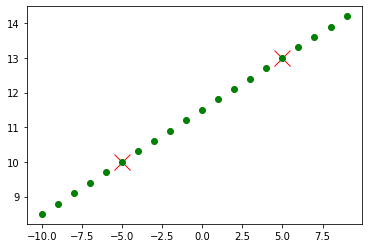

In [5]:
# test linear interpolation
point1 = (-5, 10)
point2 = (5, 13)

plt.plot(point1[0], point1[1], 'rx', markersize=16)
plt.plot(point2[0], point2[1], 'rx', markersize=16)

for x in range(-10, 10):
    y = linear_interpolation(x, point1[0], point1[1], point2[0], point2[1])
    plt.plot(x, y, 'go')


plt.show()

In [6]:
def et_curve_from_pandas_row(row: pd.core.series.Series) -> et_curve:
    baseline = row['Grunnlast']

    dx = []
    dy = []
    for i in range(1,7):
        x = row[f'DX{i}']
        y = row[f'DY{i}']
        if (not np.isnan(x)) and (not np.isnan(y)):
            dx.append(x)
            dy.append(y)

    return et_curve(baseline, dx, dy)


-30 is below range, lowest point is (-15.0, 12800.0)
temp: -30 expected: 18094.1 kWh/uke
-29 is below range, lowest point is (-15.0, 12800.0)
temp: -29 expected: 17741.2 kWh/uke
-28 is below range, lowest point is (-15.0, 12800.0)
temp: -28 expected: 17388.2 kWh/uke
-27 is below range, lowest point is (-15.0, 12800.0)
temp: -27 expected: 17035.3 kWh/uke
-26 is below range, lowest point is (-15.0, 12800.0)
temp: -26 expected: 16682.4 kWh/uke
-25 is below range, lowest point is (-15.0, 12800.0)
temp: -25 expected: 16329.4 kWh/uke
-24 is below range, lowest point is (-15.0, 12800.0)
temp: -24 expected: 15976.5 kWh/uke
-23 is below range, lowest point is (-15.0, 12800.0)
temp: -23 expected: 15623.5 kWh/uke
-22 is below range, lowest point is (-15.0, 12800.0)
temp: -22 expected: 15270.6 kWh/uke
-21 is below range, lowest point is (-15.0, 12800.0)
temp: -21 expected: 14917.6 kWh/uke
-20 is below range, lowest point is (-15.0, 12800.0)
temp: -20 expected: 14564.7 kWh/uke
-19 is below range, l

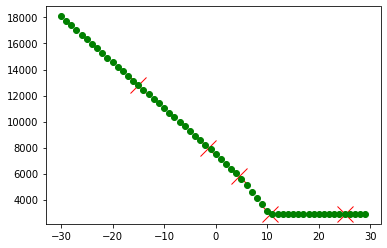

In [7]:
test_et = et_curve_from_pandas_row(energy_temperature_df.loc[278])

for x, y in zip(test_et.dx, test_et.dy):
    plt.plot(x, y, 'rx', markersize=16)

for x in range(-30, 30):
    prediction = test_et.expected(x)
    print(f'temp: {x} expected: {prediction:.1f} kWh/uke')
    plt.plot(x, prediction, 'go')

plt.show()

In [8]:
energy_consumption_and_temp_df = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', parse_dates=['Unnamed: 0'], decimal=',', sheet_name='Export_4')
energy_consumption_and_temp_df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
energy_consumption_and_temp_df.set_index('datetime', inplace=True)

In [9]:
temp_voll = energy_consumption_and_temp_df['Eklima_68860_TAM']

In [10]:
temp_voll

datetime
2015-01-01 00:00:00    3.6
2015-01-01 01:00:00    3.6
2015-01-01 02:00:00    3.6
2015-01-01 03:00:00    3.6
2015-01-01 04:00:00    3.6
                      ... 
2020-01-01 19:00:00    7.4
2020-01-01 20:00:00    7.4
2020-01-01 21:00:00    7.4
2020-01-01 22:00:00    7.4
2020-01-01 23:00:00    7.4
Name: Eklima_68860_TAM, Length: 43848, dtype: float64

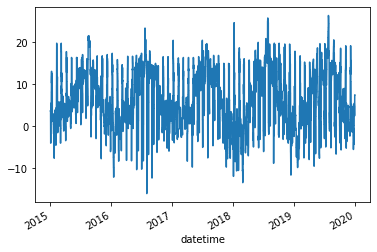

In [11]:
temp_voll.plot()
plt.show()

In [12]:
energy_consumption_and_temp_weekly_df = energy_consumption_and_temp_df.resample('W-MON').sum()

In [13]:
energy_consumption_df = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', parse_dates=['Unnamed: 0'], decimal=',', sheet_name='Export_1')
energy_consumption_df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
energy_consumption_df.set_index('datetime', inplace=True)
energy_consumption_weekly_df = energy_consumption_df.resample('W-MON').sum()

In [14]:
energy_consumption_weekly_df['707057500068616428']

datetime
2015-01-05     927.2
2015-01-12    1954.4
2015-01-19    2065.0
2015-01-26    2189.0
2015-02-02    2391.4
               ...  
2019-12-09    1930.0
2019-12-16    1806.0
2019-12-23    1975.0
2019-12-30    1364.0
2020-01-06     307.0
Freq: W-MON, Name: 707057500068616428, Length: 262, dtype: float64

In [15]:
energy_consumption_weekly_series = energy_consumption_weekly_df['707057500068616428'] + energy_consumption_weekly_df['ESAVE_89434-980396002_EAN']

In [16]:
temp_voll_weekly_mean = temp_voll.resample('W-MON').mean()

In [17]:
et_prediction_weekly = temp_voll_weekly_mean.apply(test_et.expected)

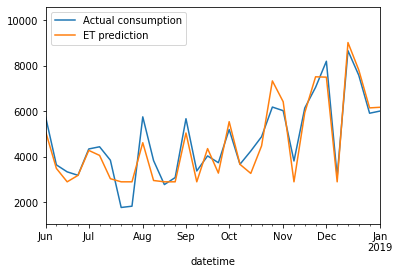

In [18]:
start_plot = datetime(2018, 6, 1, 1)
stop_plot = datetime(2019, 1, 1, 0)

consumption_subplot = energy_consumption_weekly_series.plot(xlim=(start_plot, stop_plot))
prediction_subplot = et_prediction_weekly.plot(xlim=(start_plot, stop_plot))
plt.legend(['Actual consumption', 'ET prediction'])
plt.show()

In [19]:
energy_consumption_difference_weekly_et = energy_consumption_weekly_series - et_prediction_weekly
energy_consumption_difference_proportional_weekly_et = energy_consumption_difference_weekly_et / et_prediction_weekly
energy_consumption_difference_precent_weekly_et = energy_consumption_difference_proportional_weekly_et * 100

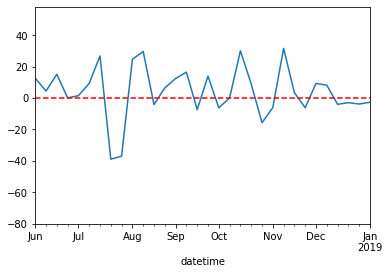

In [20]:
energy_consumption_difference_precent_weekly_et.plot(xlim=(start_plot, stop_plot))
plt.axhline(y=0, color='r', linestyle='--')
plt.show()